In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns 


In [59]:
df = pd.read_excel('online_retail_II.xlsx')

In [60]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [62]:
df.Country.isnull().sum()

np.int64(0)

In [63]:
df.dropna(subset=['Customer ID'], inplace=True)
df = df[df['Quantity'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

C:\Users\praty\AppData\Local\Temp\ipykernel_8540\746953261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [64]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.dropna(subset=['Customer ID'])  # Remove rows with missing customer IDs
df['Customer ID'] = df['Customer ID'].astype(str)

C:\Users\praty\AppData\Local\Temp\ipykernel_8540\2185393385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [65]:
# Create a new feature Total Price
df['TotalPrice'] = df['Quantity'] * df['Price']

# Remove cancellations (Invoice with 'C' means Cancelled)
df = df[~df['Invoice'].astype(str).str.startswith('C')]

In [66]:
reference_date = df['InvoiceDate'].max()  # custom cutoff date


In [67]:
recency = df.groupby('Customer ID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (reference_date - recency['InvoiceDate']).dt.days


In [68]:
frequency = df.groupby('Customer ID')['Invoice'].nunique().reset_index()
frequency.columns = ['Customer ID', 'Frequency']


In [69]:
monetary = df.groupby('Customer ID')['TotalPrice'].sum().reset_index()
monetary.columns = ['Customer ID', 'Monetary']


In [70]:
aov = df.groupby('Customer ID')['TotalPrice'].mean().reset_index()
aov.columns = ['Customer ID', 'AOV']


In [71]:
features = recency.merge(frequency, on='Customer ID')
features = features.merge(monetary, on='Customer ID')
features = features.merge(aov, on='Customer ID')


In [72]:
features = features.rename(columns={'Monetary': 'LTV'})


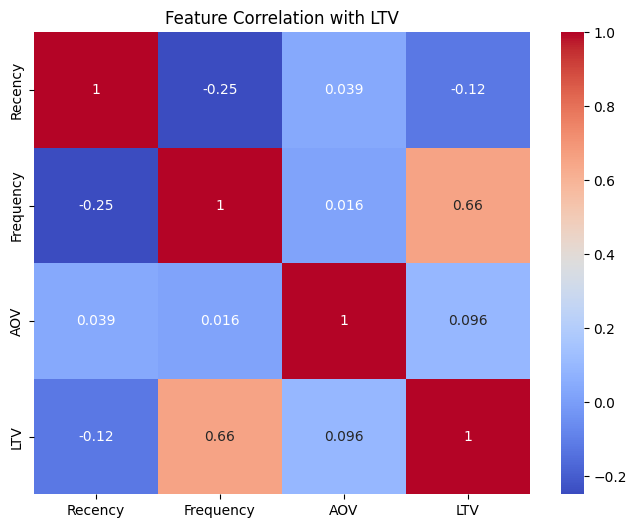

In [73]:
# Correlation Heatmap (feature Selection)
plt.figure(figsize=(8, 6))
sns.heatmap(features[['Recency', 'Frequency', 'AOV', 'LTV']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with LTV")
plt.show()

In [74]:
from sklearn.model_selection import train_test_split,GridSearchCV

X = features[['Recency', 'Frequency', 'AOV']]
y = features['LTV']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [77]:
#Model training
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse})

In [78]:
results_df = pd.DataFrame(results)
print(results_df)

               Model          MAE          RMSE
0  Linear Regression  1971.319269   6741.714271
1      Decision Tree  1932.609110  11418.251058
2      Random Forest  1393.972691   7160.355870
3            XGBoost  1620.883822   8380.427541
4  Gradient Boosting  1492.194798  10040.204562


In [79]:
#Parameter Tuning for Random Forest Model(Best Fit Model)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}
best_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_absolute_error')
best_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error')

In [80]:
features['Predicted_LTV'] = best_rf.predict(features[['Recency', 'Frequency', 'AOV']])

In [81]:
features['Segment'] = pd.qcut(features['Predicted_LTV'], 3, labels=['Low', 'Medium', 'High'])

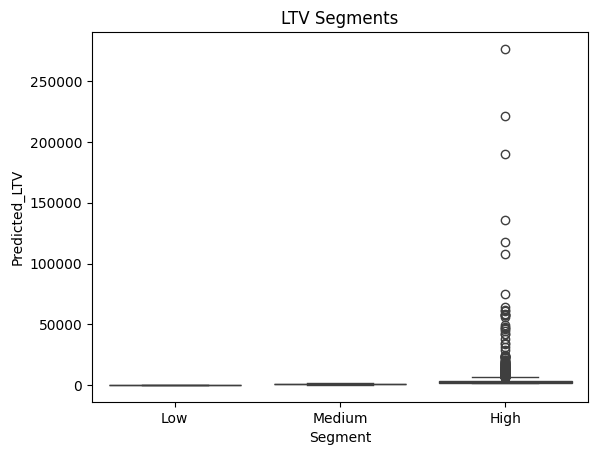

In [82]:
#Visuliazing Insights
sns.boxplot(x='Segment', y='Predicted_LTV', data=features)
plt.title("LTV Segments")
plt.show()


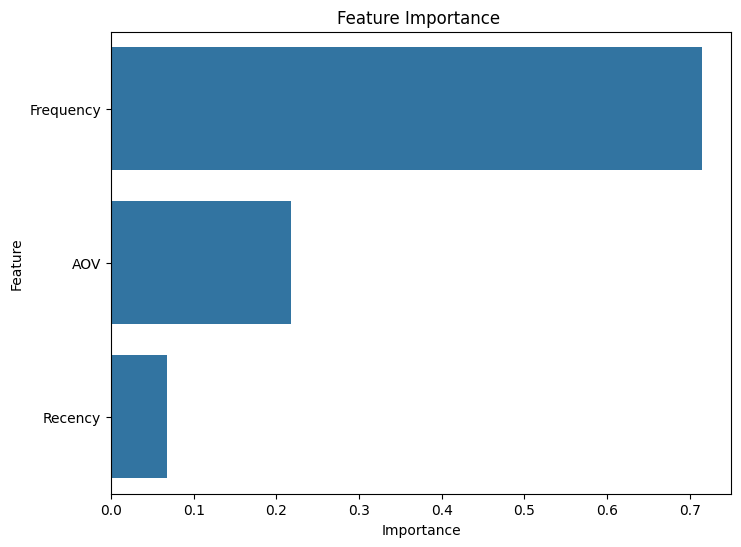

In [83]:
importances = best_rf.best_estimator_.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
#Feature Importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance ")
plt.show()


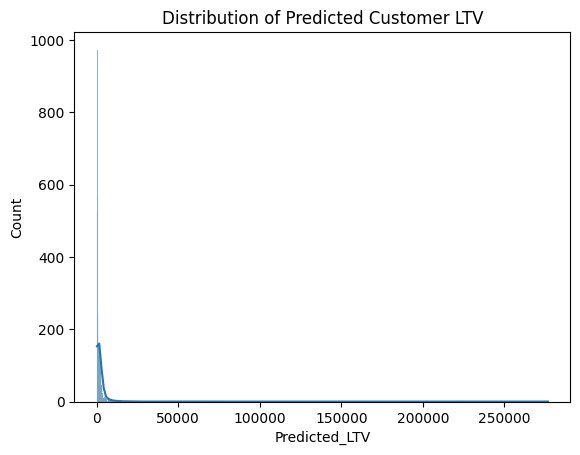

In [84]:
# Distribution of Predicted LTV
sns.histplot(features['Predicted_LTV'], kde=True)
plt.title("Distribution of Predicted Customer LTV")
plt.show()


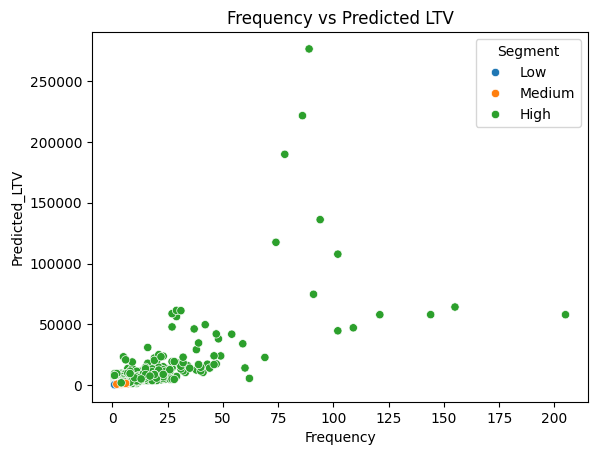

In [85]:
# Scatterplot of LTV vs Frequency
sns.scatterplot(data=features, x='Frequency', y='Predicted_LTV', hue='Segment')
plt.title("Frequency vs Predicted LTV")
plt.show()

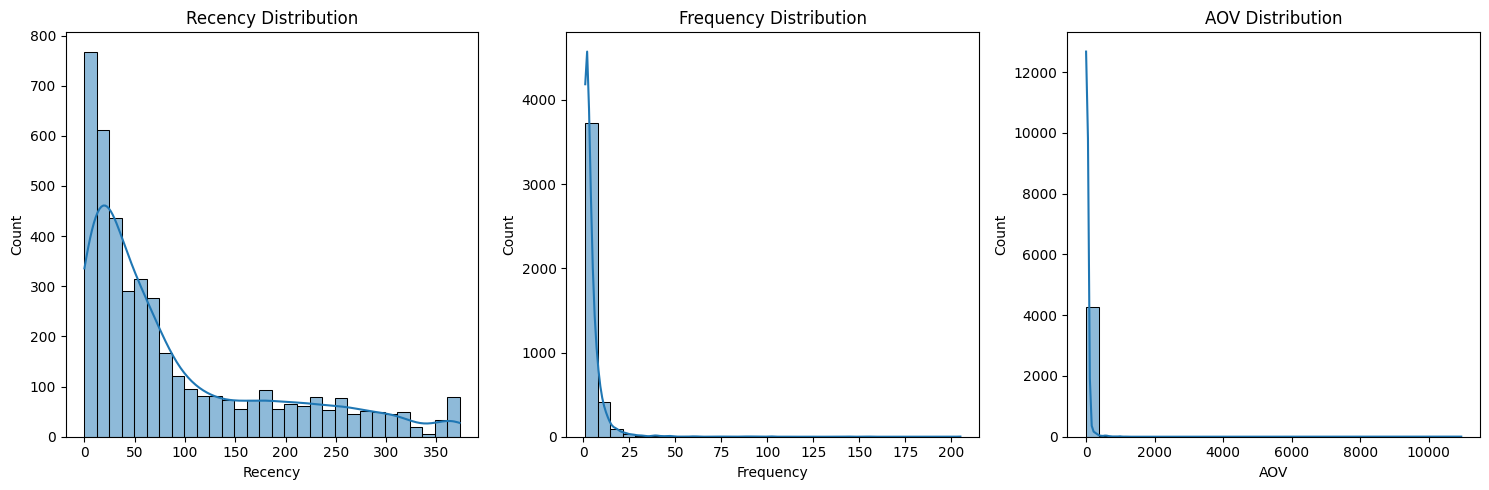

In [86]:
# Feature Distributions
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Recency', 'Frequency', 'AOV']):
    plt.subplot(1, 3, i+1)
    sns.histplot(features[col], kde=True, bins=30)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()


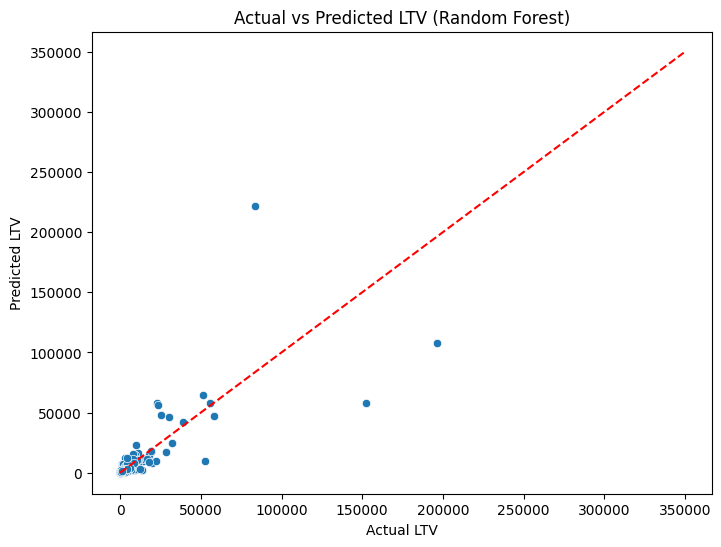

In [87]:
# Predicted vs Actual LTV
best_model_preds = best_rf.predict(X_test)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=best_model_preds)
plt.xlabel("Actual LTV")
plt.ylabel("Predicted LTV")
plt.title("Actual vs Predicted LTV (Random Forest)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # Line of perfect prediction
plt.show()


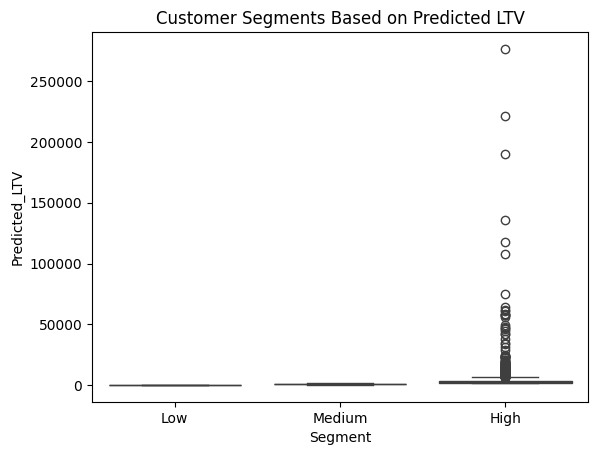

In [ ]:
#Customer Segments Based on Predicted LTV
sns.boxplot(x='Segment', y='Predicted_LTV', data=features)
plt.title("Customer Segments Based on Predicted LTV")
plt.show()


C:\Users\praty\AppData\Local\Temp\ipykernel_8540\1691746020.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_revenue.values, y=country_revenue.index, palette='viridis')


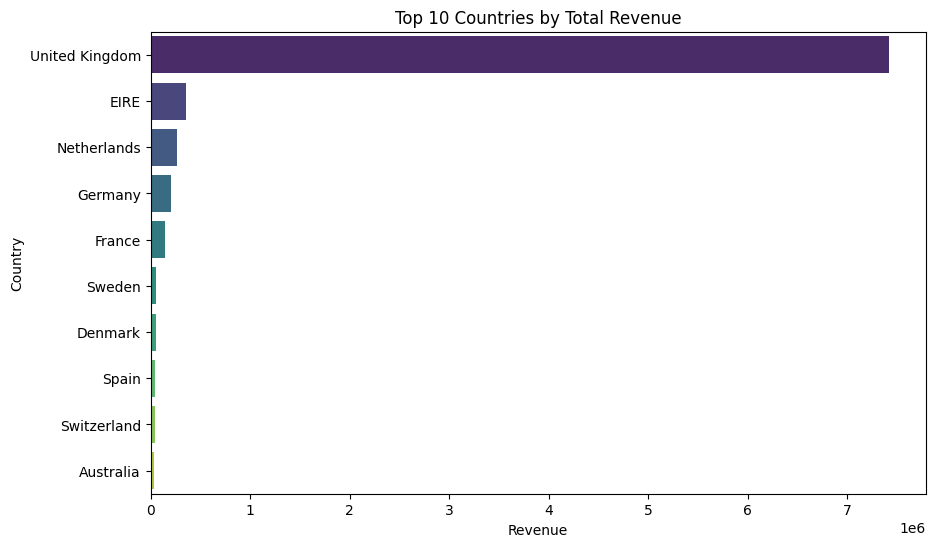

In [89]:
# Total revenue by country
country_revenue = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=country_revenue.values, y=country_revenue.index, palette='viridis')
plt.title("Top 10 Countries by Total Revenue")
plt.xlabel("Revenue")
plt.ylabel("Country")
plt.show()


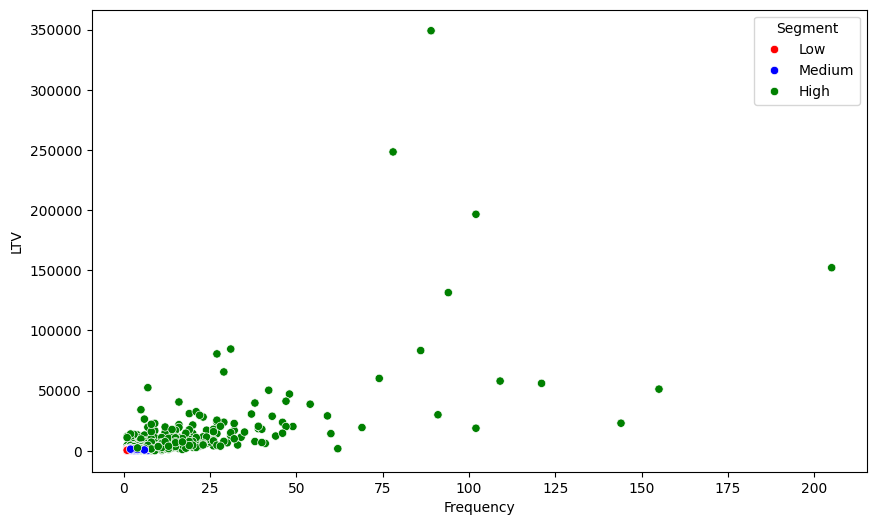

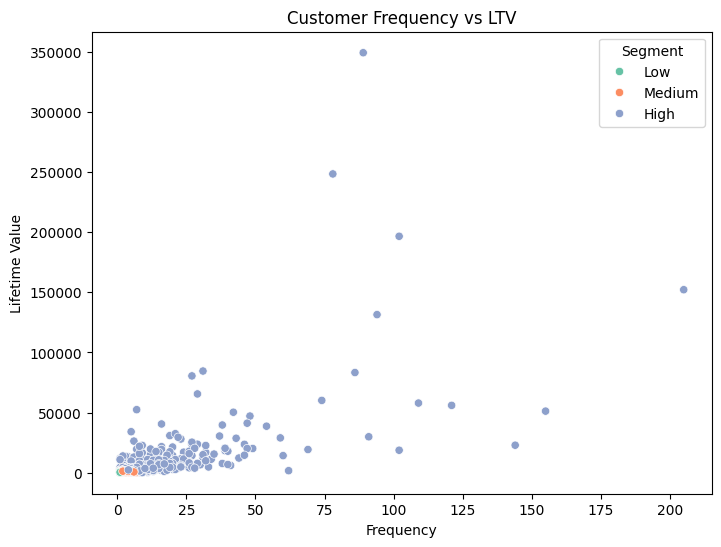

In [90]:
#Customer Frequency vs LTV
filtered_features = features[features['LTV'] > 0]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Frequency',
    y='LTV',
    hue='Segment',
    data=filtered_features,
    palette={'Low': 'red', 'Medium': 'blue', 'High': 'green'}
)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=features, x='Frequency', y='LTV', hue='Segment', palette='Set2')
plt.title("Customer Frequency vs LTV")
plt.xlabel("Frequency")
plt.ylabel("Lifetime Value")
plt.show()


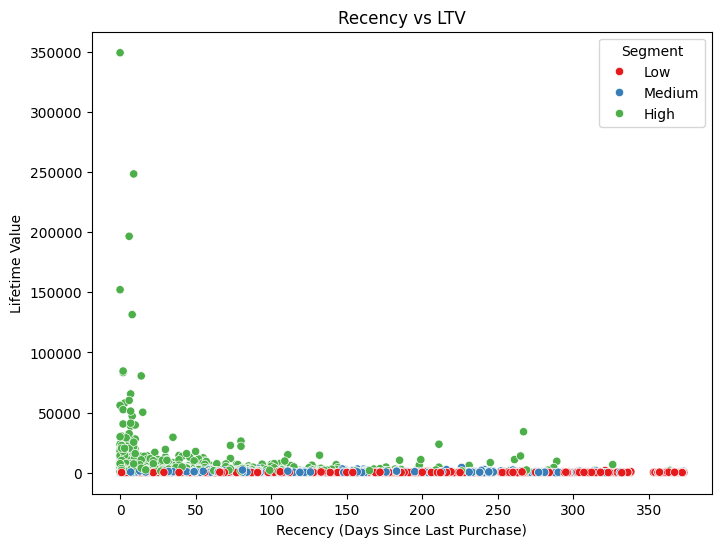

In [91]:
#Recency vs LTV
plt.figure(figsize=(8, 6))
sns.scatterplot(data=features, x='Recency', y='LTV', hue='Segment', palette='Set1')
plt.title("Recency vs LTV")
plt.xlabel("Recency (Days Since Last Purchase)")
plt.ylabel("Lifetime Value")
plt.show()


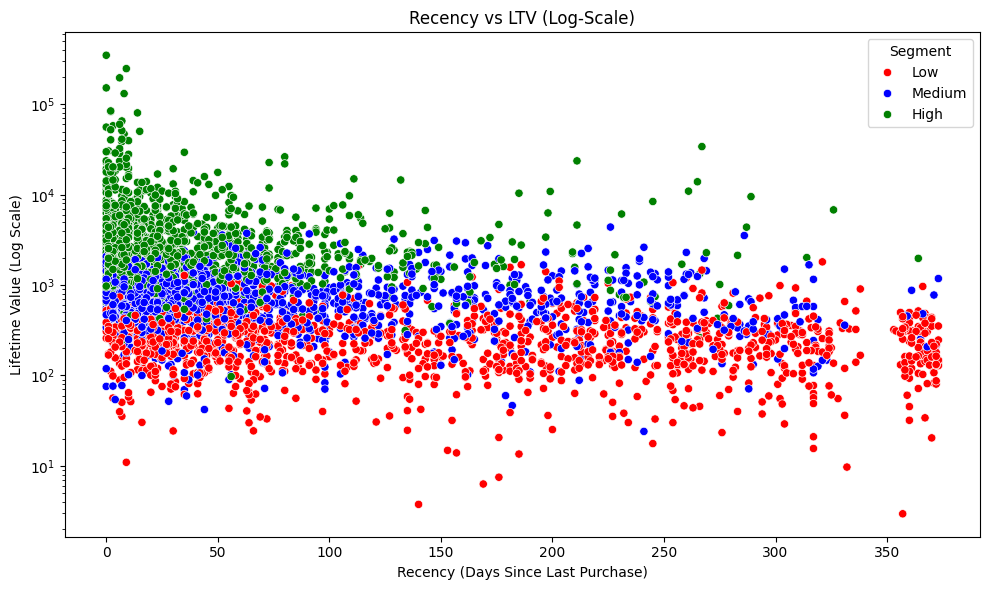

In [92]:
# Filter to remove non-positive LTV values
filtered_features = features[features['LTV'] > 0]

# Create the log-scale scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Recency',
    y='LTV',
    hue='Segment',
    data=filtered_features,
    palette={'Low': 'red', 'Medium': 'blue', 'High': 'green'}
)
plt.yscale('log')  # Apply log scale
plt.title("Recency vs LTV (Log-Scale)")
plt.xlabel("Recency (Days Since Last Purchase)")
plt.ylabel("Lifetime Value (Log Scale)")
plt.legend(title='Segment')
plt.tight_layout()
plt.show()


C:\Users\praty\AppData\Local\Temp\ipykernel_8540\2613985953.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_revenue = df_ts.resample('M')['TotalPrice'].sum()


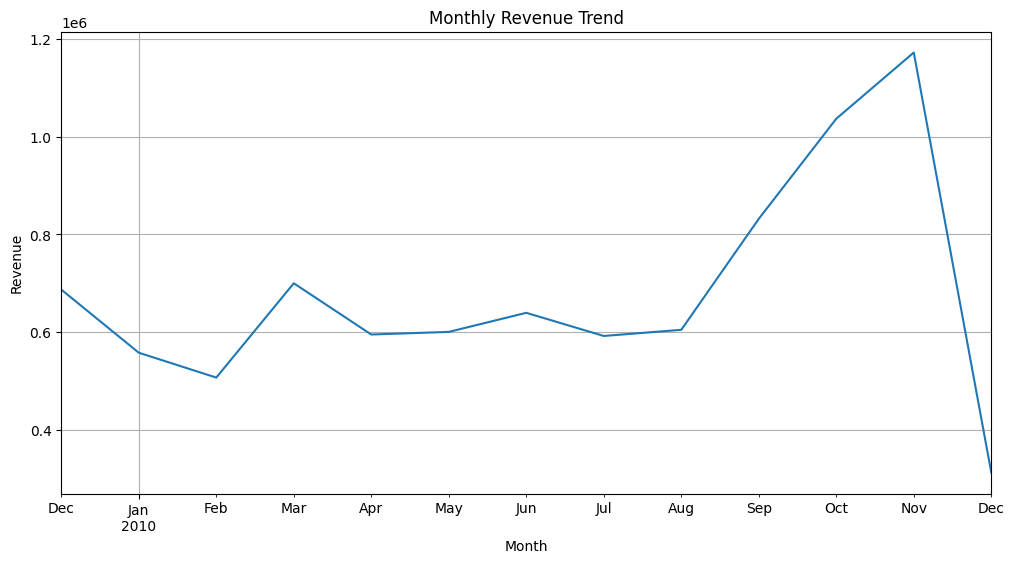

In [93]:
#Monthly Revenue Trend
df_ts = df.set_index('InvoiceDate')
monthly_revenue = df_ts.resample('M')['TotalPrice'].sum()

plt.figure(figsize=(12, 6))
monthly_revenue.plot()
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()


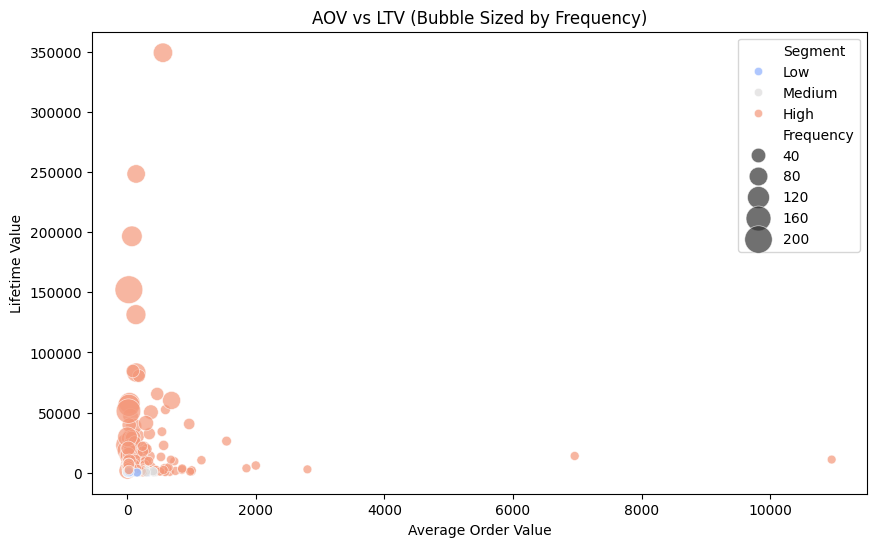

In [94]:
#AOV vs LTV 
filtered_features = features[features['LTV'] > 0]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features, x='AOV', y='LTV', size='Frequency', hue='Segment', alpha=0.7, palette='coolwarm', sizes=(40, 400))
plt.title("AOV vs LTV (Bubble Sized by Frequency)")
plt.xlabel("Average Order Value")
plt.ylabel("Lifetime Value")
plt.legend()
plt.show()
